In [1]:
! pip install -q kaggle
! pip install datasets
! pip install -U accelerate
! pip install -U transformers[torch]
! pip install jiwer
from datasets import Dataset, DatasetDict
import numpy as np
import pandas as pd
!pip install evaluate
import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

## Load the data

Pökemon blip dataset (images and caption)

In [2]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds

DatasetNotFoundError: Dataset 'lambdalabs/pokemon-blip-captions' is a gated dataset on the Hub. You must be authenticated to access it.

The dataset is gated and my application is still pending. We need an alternative. Let's check Kaggle. We'ill import two datasets, one with descriptions of pokemon, the other with images of Pokemon.

In [3]:
from google.colab import files
!kaggle datasets download serquet/pokemon-name-description-small
!kaggle datasets download arenagrenade/the-complete-pokemon-images-data-set

Dataset URL: https://www.kaggle.com/datasets/serquet/pokemon-name-description-small
License(s): unknown
  0% 0.00/1.41k [00:00<?, ?B/s]
100% 1.41k/1.41k [00:00<00:00, 3.31MB/s]
Dataset URL: https://www.kaggle.com/datasets/arenagrenade/the-complete-pokemon-images-data-set
License(s): CC0-1.0
100% 111M/111M [00:08<00:00, 18.5MB/s]
100% 111M/111M [00:08<00:00, 13.9MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/pokemon-name-description-small.zip','r')
zip_ref.extractall('/content/')
zip_ref = zipfile.ZipFile('/content/the-complete-pokemon-images-data-set.zip','r')
zip_ref.extractall('/content/')
zip_ref.close()

We first put the pokemon descriptions in a pandas dataframe

In [6]:
descriptions = pd.read_csv('/content/pokemon_description.csv')
descriptions.head()

description       name
0         a drawing of a green pokemon with red eyes  Bulbasaur
1             a green and yellow toy with a red nose   Caterpie
2  a red and white ball with an angry look on its...    Voltorb
3           a cartoon ball with a smile on it's face  Electrode
4          a bunch of balls with faces drawn on them  Exeggcute

We then create a dictionary with the pokemon images and their names

In [7]:
from PIL import Image
import os

# Get the path of the dataset
dataset_path = "/content/Pokemon Dataset"

# Create an empty dictionary to store the images
images_dict = {}

# Loop through each file in the dataset
for filename in os.listdir(dataset_path):
  # Check if the file is a PNG image
  if filename.endswith(".png"):
    # Get the name of the image without the extension
    image_name = os.path.splitext(filename)[0]

    # Open the image and store it in the dictionary
    image_path = os.path.join(dataset_path, filename)
    image = Image.open(image_path)
    images_dict[image_name] = image

# Now the `images_dict` dictionary contains all the images with their names as keys

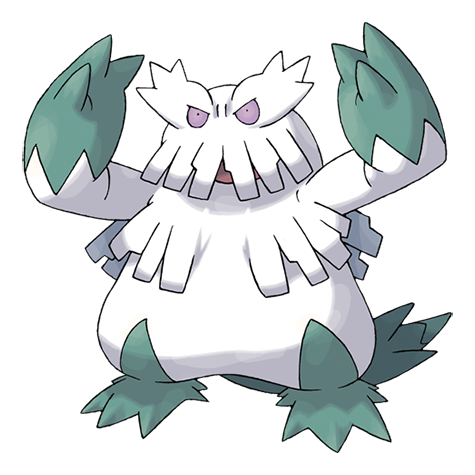

In [8]:
images_dict['abomasnow']

Let's filter the images to keep only those associated with a description

We the descriptions with a "Mega " in the name and change the name "Mr. Mime"

In [9]:
to_delete = ['Mega Kangaskhan','Mega Gyarados','Mega Aerodactyl',
             'Mega Beedrill','Mega Mewtwo X','Mega Mewtwo Y',]
descriptions = descriptions[~descriptions['name'].isin(to_delete)]
descriptions.loc[descriptions['name']== 'Mr. Mime', 'name'] = 'mr-mime'

labels = descriptions['name'].values.tolist()
images_desc = []
for label in labels:
  images_desc.append(images_dict[label.lower()])

<ipython-input-9-0ae00fee3047>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions.loc[descriptions['name']== 'Mr. Mime', 'name'] = 'mr-mime'


Now we can create a HuggingFace Dataset

In [10]:
dataset = Dataset.from_dict({
    'image': images_desc,
    'text': descriptions['description']
})
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 67
})

We only have 67 rows (compared with 833 in the pokemon blip dataset)

Let's visualize a couple of images with their associated description

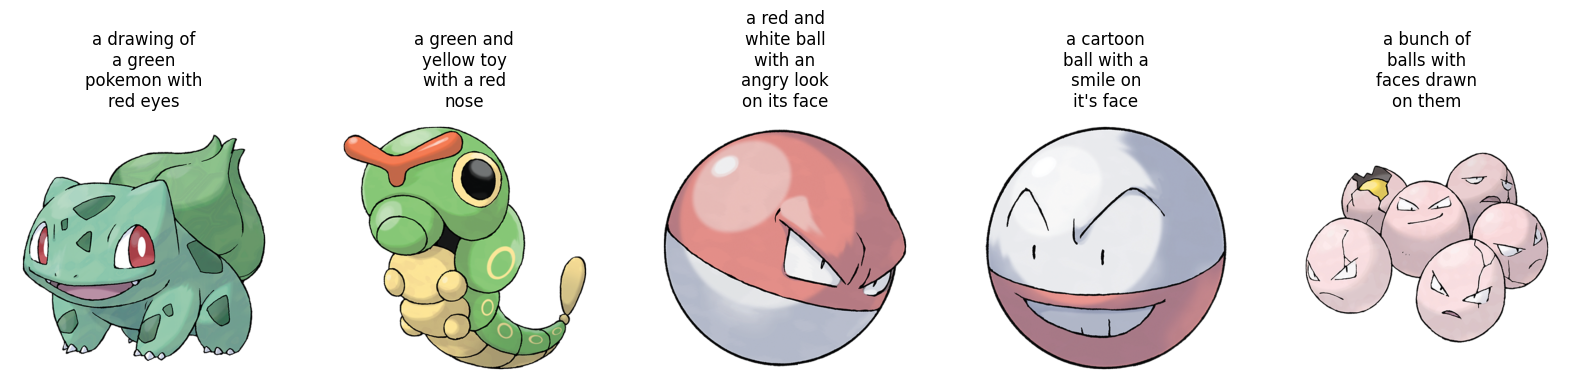

In [11]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(dataset[i]["image"]) for i in range(5)]
sample_captions = [dataset[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Process the dataset

Model to process both images and captions

In [12]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [13]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


dataset.set_transform(transforms)

Load the model

In [14]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Word Error Rate metric

In [15]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Train the model

In [16]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
    hub_token='',
)

Because our dataset is so small (67 observations), we put eval dataset = train dataset

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


TrainOutput(global_step=200, training_loss=0.757731706649065, metrics={'train_runtime': 208.5538, 'train_samples_per_second': 16.063, 'train_steps_per_second': 0.959, 'total_flos': 1393694260715520.0, 'train_loss': 0.757731706649065, 'epoch': 44.44444444444444})

## Inference

Manually upload an image (we take a pikachu for the example)

Saving pikachu jpeg.jpg to pikachu jpeg.jpg


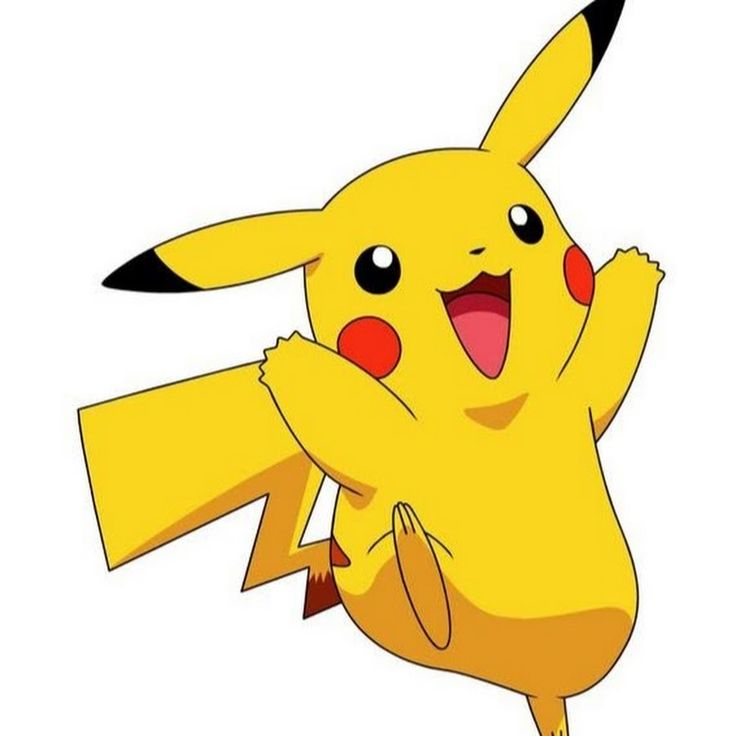

In [112]:
from google.colab import files
uploaded = files.upload()

from io import BytesIO
from PIL import Image

im = Image.open(BytesIO(uploaded['pikachu jpeg.jpg']))
im

Process the uploaded image

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=im, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

Generate the description

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a drawing of a yellow creature with a black nose


It's pretty good! But is pikachu in the dataset?

In [ ]:
descriptions[descriptions['name']=="Pikachu"]

Empty DataFrame
Columns: [description, name]
Index: []

Pikachu wasn't in the training dataset so it's an out-of-sample example.

## Alternative (larger) dataset

I think the pokemon blip dataset is availble here (at least it's a bigger pokemon description dataset). Let's download it

In [18]:
!kaggle datasets download thedevastator/pokemon-llava-images-and-text-descriptions

Dataset URL: https://www.kaggle.com/datasets/thedevastator/pokemon-llava-images-and-text-descriptions
License(s): CC0-1.0
100% 447M/447M [00:26<00:00, 12.5MB/s]
100% 447M/447M [00:26<00:00, 17.5MB/s]


In [19]:
zip_ref = zipfile.ZipFile('/content/pokemon-llava-images-and-text-descriptions.zip','r')
zip_ref.extractall('/content/')
zip_ref.close()

In [59]:
from datasets import load_dataset
data_files = {'train': 'train.csv'}
dataset_large = load_dataset('csv', data_files=data_files)

In [60]:
dataset_large["train"]["text"][0]

'A cartoon drawing of a green Pokemon with a leaf on its back.'

Let's look at an image:

In [61]:
dataset_large["train"]["image"][0]

'{\'bytes\': b\'\\x89PNG\\r\\n\\x1a\\n\\x00\\x00\\x00\\rIHDR\\x00\\x00\\x05\\x00\\x00\\x00\\x05\\x00\\x08\\x02\\x00\\x00\\x00\\x97\\x86h\\xa0\\x00\\x00\\n0iCCPICC Profile\\x00\\x00x\\x9c\\x9d\\x96wTT\\xd7\\x16\\x87\\xcf\\xbdwz\\xa1\\xcd0\\x14)C\\xef\\xbd\\r \\xbd7\\xa9\\xd2Da\\x98\\x19`(\\x03\\x0e34\\xb1!\\xa2\\x02\\x11ED\\x04\\x15A\\x82"\\x06\\x8c\\x86"\\xb1"\\x8a\\x85\\x80`\\xc1\\x1e\\x90 \\xa0\\xc4`\\x14QQy3\\xb2Vt\\xe5\\xe5\\xbd\\x97\\x97\\xdf\\x1fg}k\\x9f\\xbd\\xf7=g\\xef}\\xd6\\xba\\x00\\x90\\xbc\\xfd\\xb9\\xbctX\\n\\x804\\x9e\\x80\\x1f\\xe2\\xe5J\\x8f\\x8c\\x8a\\xa6c\\xfb\\x01\\x0c\\xf0\\x00\\x03\\xcc\\x00`\\xb223\\x02B=\\xc3\\x80H>\\x1en\\xf4L\\x91\\x13\\xf8"\\x08\\x807w\\xc4+\\x007\\x8d\\xbc\\x83\\xe8t\\xf0\\xffI\\x9a\\x95\\xc1\\x17\\x88\\xd2\\x04\\x89\\xd8\\x82\\xcd\\xc9d\\x89\\xb8P\\xc4\\xa9\\xd9\\x82\\x0c\\xb1}F\\xc4\\xd4\\xf8\\x141\\xc3(1\\xf3E\\x07\\x14\\xb1\\xbc\\x98\\x13\\x17\\xd9\\xf0\\xb3\\xcf";\\x8b\\x99\\x9d\\xc6c\\x8bX|\\xe6\\x0cv\\x1a[\\xcc="\\xde\\x9a%\\xe4\\x88\

Strange format (not an actual image), we need to process it. First we use a function to convert byte array into a PIL image.

In [62]:
import PIL
import io

def convert_bytes_to_Image(byte_array) :
    return Image.open(io.BytesIO((ast.literal_eval(byte_array)['bytes'])))

Display the image

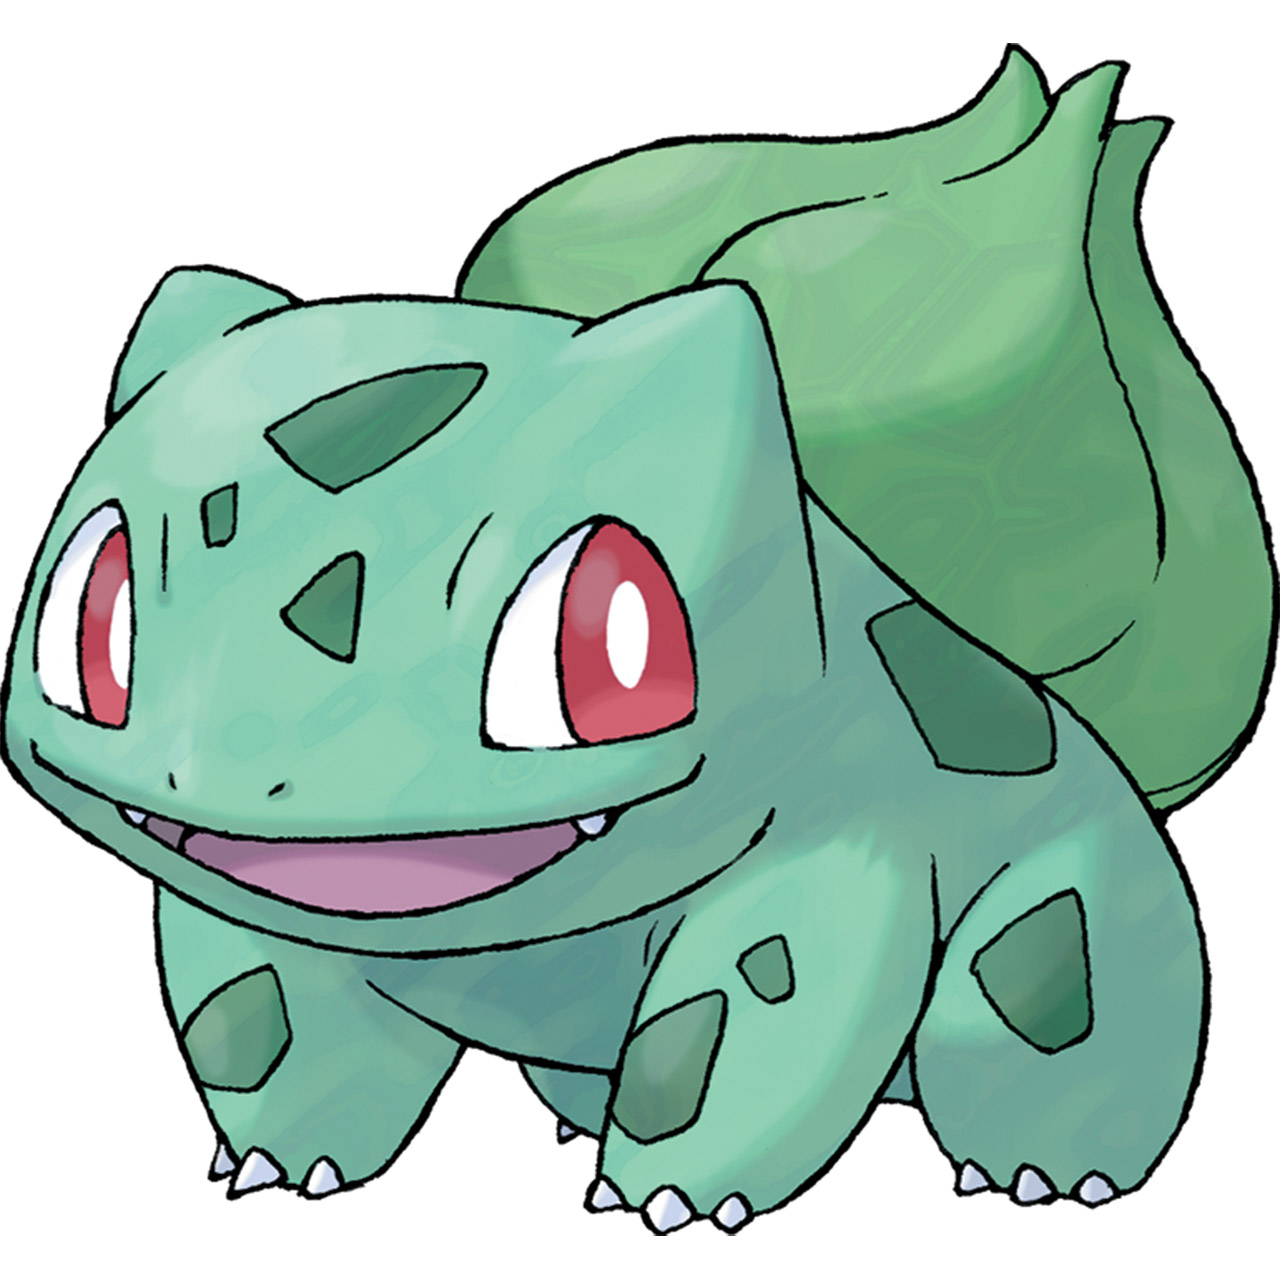

In [63]:
import ast

img = dataset_large["train"]["image"][0]
PIL_image = convert_bytes_to_Image(img)
display(PIL_image)

It works (huge image!). Let's split the dataset to get a test set:

In [64]:
dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

Display images + caption to see if everything is ok:

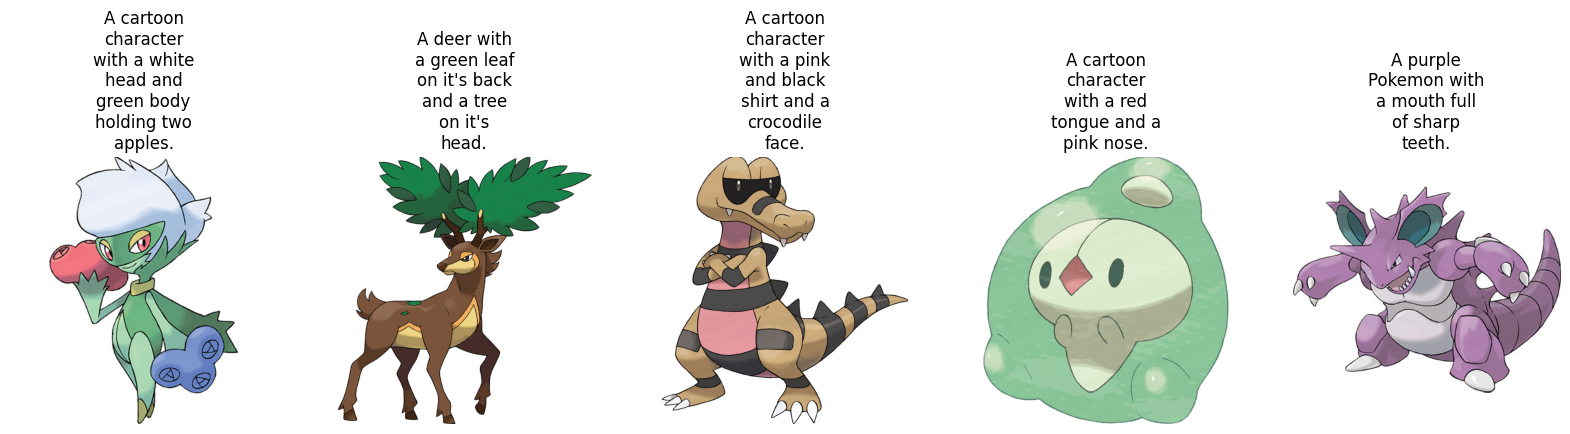

In [65]:
sample_images_to_visualize = [np.array(convert_bytes_to_Image(train_ds[i]["image"])) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

We convert all the images in the training and test datasets to be usable by the model:

In [83]:
train_images = [convert_bytes_to_Image(train_ds[i]["image"]) for i in range(len(train_ds))]
train_text = [train_ds[i]["text"] for i in range(len(train_ds))]
test_images = [convert_bytes_to_Image(test_ds[i]["image"]) for i in range(len(test_ds))]
test_text = [test_ds[i]["text"] for i in range(len(test_ds))]

train_ds2 = Dataset.from_dict({"image": train_images, "text": train_text})
test_ds2 = Dataset.from_dict({"image": test_images, "text": test_text})

In [87]:
train_ds2.set_transform(transforms)
test_ds2.set_transform(transforms)

Train the model

In [88]:
trainer2 = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds2,
    eval_dataset=test_ds2,
    compute_metrics=compute_metrics,
)

In [89]:
trainer2.train()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Unused or unrecognized kwargs: padding.


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


TrainOutput(global_step=2350, training_loss=0.20397733304927007, metrics={'train_runtime': 3546.5042, 'train_samples_per_second': 10.56, 'train_steps_per_second': 0.663, 'total_flos': 1.75147147865088e+16, 'train_loss': 0.20397733304927007, 'epoch': 50.0})

Graph of the training and test losses:

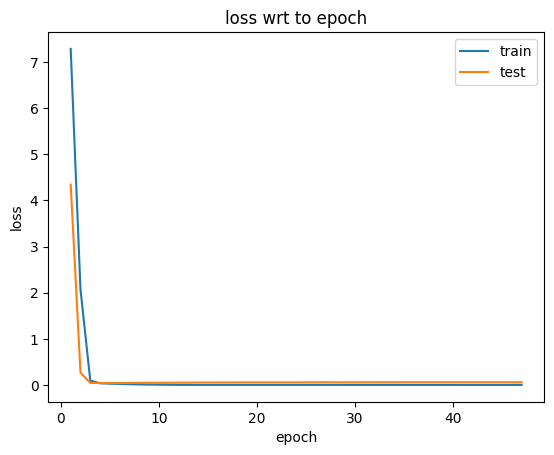

In [110]:
training_loss = []
for i in range(0, len(trainer2.state.log_history)-1, 2):
  training_loss.append(trainer2.state.log_history[i]['loss'])

test_loss = []
for i in range(1, len(trainer2.state.log_history), 2):
  test_loss.append(trainer2.state.log_history[i]['eval_loss'])

loss = [training_loss,test_loss]
x = np.arange(1,48,1)

plt.plot(x,loss[0],x,loss[1])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train','test'])
plt.title('loss wrt to epoch')
plt.show()

There is a bit of overfitting but it's invisible on the graph, so not really a problem.  

Inference

Saving dugtrio.jpg to dugtrio.jpg


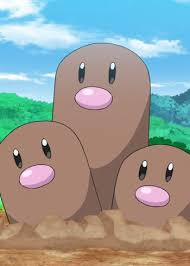

In [113]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['dugtrio.jpg']))
im

In [114]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=im, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a cartoon character with a pink nose and green leaves on its head.
